In [1]:
!pip install -q -U flaml

# Imports and Configs

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from flaml import AutoML
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import glob
import os

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('husl')

2024-06-05 18:37:18,046	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-05 18:37:19,777	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
SEED = 27
N_FOLDS = 5
TARGET = 'Target'
TIME_BUDGET = 3600 * 10

# Loading and Processing the Datasets

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [5]:
original = pd.read_csv('/kaggle/input/predict-students-dropout-and-academic-success/data.csv')
train = pd.concat([train, original], axis=0, ignore_index=True)

train.shape

(80942, 37)

In [6]:
cat_features = [
    'Marital status',
    'Application mode',
    'Course',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]
for feature in cat_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')

In [7]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

# Setting up K-Fold CV and Training

In [8]:
os.mkdir('test_preds')
os.mkdir('test_pred_probs')

In [9]:
skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)

class_mapping = None
reverse_class_mapping = None

histories = {}
oof_pred_probs = np.zeros((len(train), train[TARGET].nunique()))
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx] 

    automl = AutoML()
    automl.fit(
        X_train=X_train,
        y_train=y_train,
        task="classification",
        metric='accuracy',
        time_budget=TIME_BUDGET // N_FOLDS,
        seed=SEED        
    )
    
    pred_probs = automl.predict_proba(X_val)
    preds = automl.predict(X_val)
    oof_pred_probs[val_idx] = pred_probs
    
    if class_mapping is None:
        class_mapping = {cls: idx for idx, cls in enumerate(automl.classes_)}
        reverse_class_mapping = {idx: cls for idx, cls in enumerate(automl.classes_)}
        
    preds = [class_mapping[cls] for cls in preds]
    
    accuracy = accuracy_score(y_val.map(class_mapping), preds)
    auc_score = roc_auc_score(y_val.map(class_mapping), pred_probs, multi_class='ovo')
    
    test_pred_probs = automl.predict_proba(test)
    test_preds = automl.predict(test)
    test_preds = pd.DataFrame({TARGET: test_preds}, index=test.index)
    test_preds.to_csv(f'test_preds/fold_{fold_idx}_test_preds_acc-{accuracy:.6f}.csv')
    
    test_pred_probs = pd.DataFrame(test_pred_probs, index=test.index)
    test_pred_probs.columns = [reverse_class_mapping[idx] for idx in range(test_pred_probs.shape[1])]
    test_pred_probs.to_csv(f'test_pred_probs/fold_{fold_idx}_test_pred_probs_acc-{accuracy:.6f}.csv')
    
    histories[f'Fold {fold_idx}'] = {}
    histories[f'Fold {fold_idx}']['y'] = y_val
    histories[f'Fold {fold_idx}']['pred_probs'] = pred_probs
    histories[f'Fold {fold_idx}']['preds'] = preds
    histories[f'Fold {fold_idx}']['accuracy'] = accuracy
    histories[f'Fold {fold_idx}']['auc'] = auc_score
    
    print(f'Fold {fold_idx} - Accuracy: {accuracy:.6f} - AUC: {auc_score:.6f}')
    
    del automl

[flaml.automl.logger: 06-05 18:37:23] {1680} INFO - task = classification
[flaml.automl.logger: 06-05 18:37:23] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-05 18:37:23] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 06-05 18:37:23] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 06-05 18:37:23] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-05 18:37:25] {2345} INFO - Estimated sufficient time budget=20812s. Estimated necessary time budget=511s.
[flaml.automl.logger: 06-05 18:37:25] {2392} INFO -  at 2.6s,	estimator lgbm's best error=0.2628,	best estimator lgbm's best error=0.2628
[flaml.automl.logger: 06-05 18:37:25] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-05 18:37:28] {2392} INFO -  at 5.5s,	estimator lgbm's best error=0.2628,	best estimator lgbm's best error=0.2628
[flaml.automl.logger

In [10]:
with open('flaml_oof_pred_probs.pkl', 'wb') as f:
    pickle.dump(oof_pred_probs, f)

In [11]:
histories['All'] = {}
histories['All']['accuracy'] = accuracy_score(train[TARGET].map(class_mapping), oof_pred_probs.argmax(axis=1))
histories['All']['auc'] = roc_auc_score(train[TARGET].map(class_mapping), oof_pred_probs, multi_class='ovo')
histories['All']['pred_probs'] = oof_pred_probs
histories['All']['preds'] = oof_pred_probs.argmax(axis=1)
histories['All']['y'] = train[TARGET].values

# Visualizing the Results

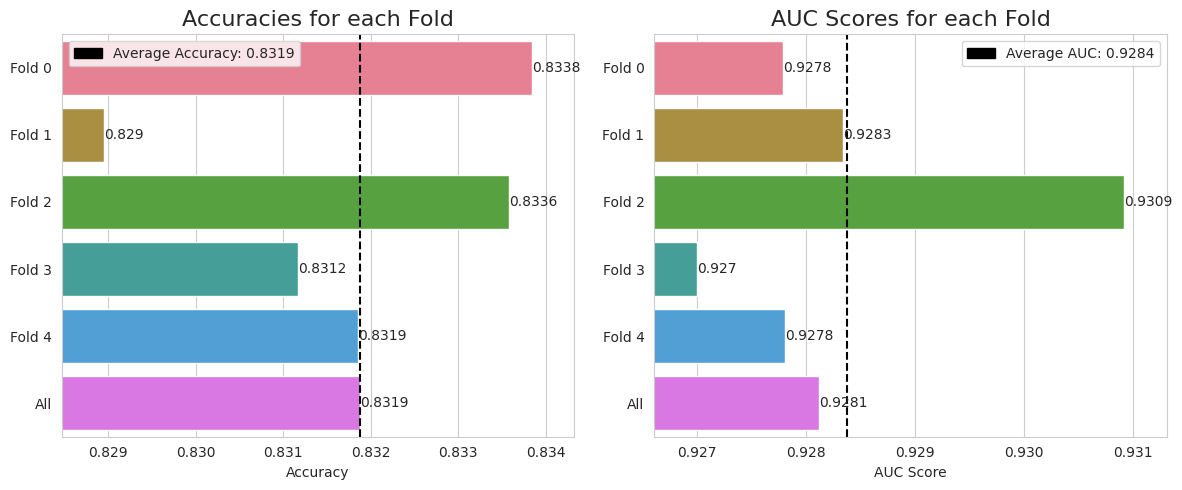

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

accuracies = [histories[f'Fold {i}']['accuracy'] for i in range(N_FOLDS)]
mean_accuracy = np.mean(accuracies)
accuracies = accuracies + [histories['All']['accuracy']]

min_acc = min(accuracies)
max_acc = max(accuracies)
acc_padding = (max_acc - min_acc) * 0.1
acc_lower_limit = min_acc - acc_padding
acc_upper_limit = max_acc + acc_padding

acc_barplot = sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=accuracies, ax=axs[0], palette='husl', orient='h')
axs[0].axvline(mean_accuracy, color='black', linestyle='--')
axs[0].set_xlim(left=acc_lower_limit, right=acc_upper_limit)
axs[0].set_xlabel('Accuracy')
axs[0].set_title('Accuracies for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average Accuracy: {mean_accuracy:.4f}')
axs[0].legend(handles=[blue_patch], loc='best')
for i, score in enumerate(accuracies):
    acc_barplot.text(score, i, round(score, 4), va = 'center')


auc_scores = [histories[f'Fold {i}']['auc'] for i in range(N_FOLDS)]
mean_auc = np.mean(auc_scores)
auc_scores = auc_scores + [histories['All']['auc']]

min_auc = min(auc_scores)
max_auc = max(auc_scores)
auc_padding = (max_auc - min_auc) * 0.1
auc_lower_limit = min_auc - auc_padding
auc_upper_limit = max_auc + auc_padding

auc_barplot = sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=auc_scores, ax=axs[1], palette='husl', orient='h')
axs[1].axvline(mean_auc, color='black', linestyle='--')
axs[1].set_xlim(left=auc_lower_limit, right=auc_upper_limit)
axs[1].set_xlabel('AUC Score')
axs[1].set_title('AUC Scores for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average AUC: {mean_auc:.4f}')
axs[1].legend(handles=[blue_patch], loc='best')
for i, score in enumerate(auc_scores):
    auc_barplot.text(score, i, round(score, 4), va = 'center')

plt.tight_layout()
plt.show()

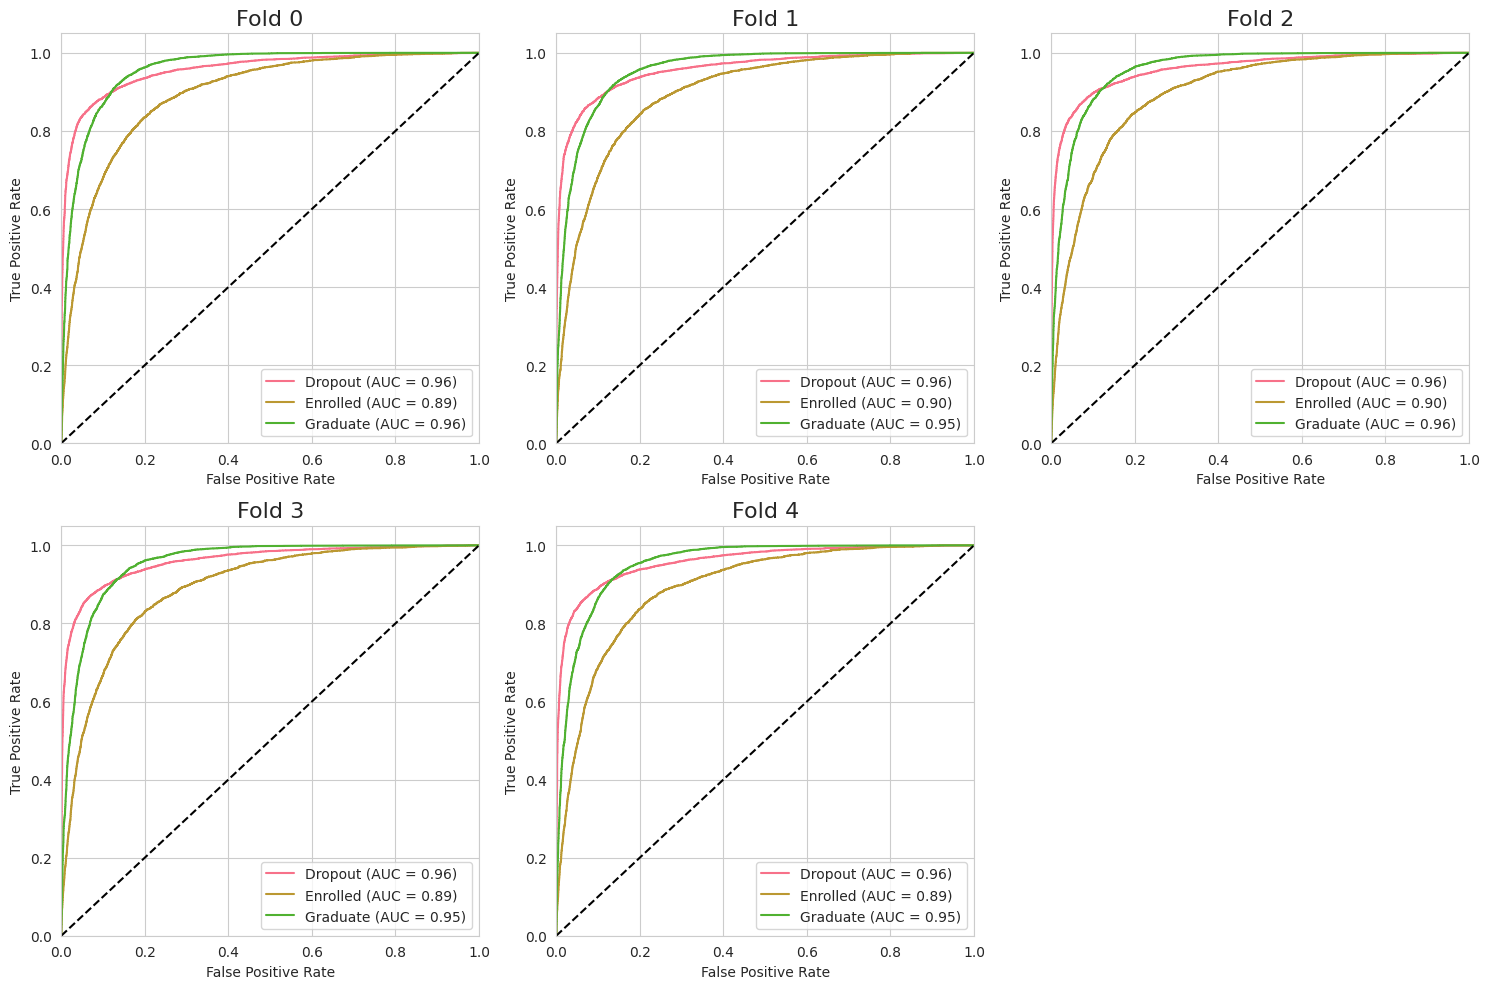

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    pred_probs = histories[f'Fold {fold_idx}']['pred_probs']
    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']
    y = np.array([class_mapping[p] for p in y])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(pred_probs.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y == i, pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(pred_probs.shape[1]):
        ax.plot(fpr[i], tpr[i], label=f'{reverse_class_mapping[i]} (AUC = {roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Fold {fold_idx}', fontsize=16)
    ax.legend()

plt.tight_layout()
plt.show()

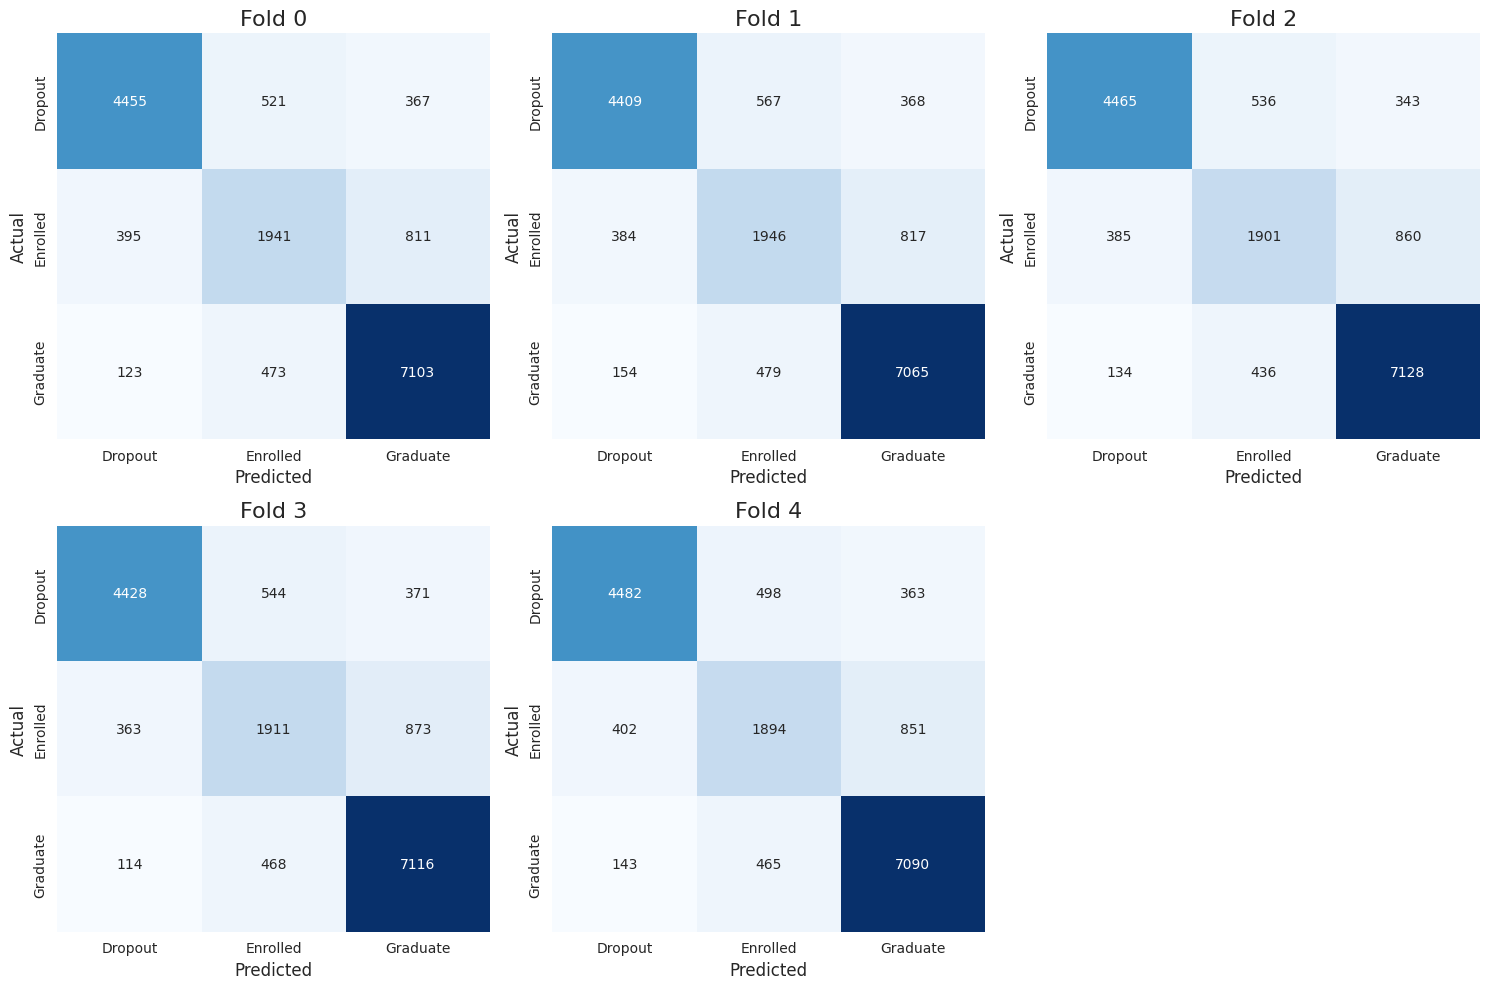

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    y = np.array([class_mapping[p] for p in y])

    cm = confusion_matrix(y, preds)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        ax=ax,
        cmap='Blues',
        cbar=False,
        xticklabels=class_mapping.keys(),
        yticklabels=class_mapping.keys()
    )

    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'Fold {fold_idx}', fontsize=16)

plt.tight_layout()
plt.show()

# Post-Processing and Inference

In [15]:
oof_files = glob.glob('test_pred_probs/fold_*_test_pred_probs_*.csv')
submissions = [pd.read_csv(f, index_col='id') for f in oof_files]

submission = pd.concat(submissions, axis=1)
submission = submission.groupby(level=0, axis=1).mean()

submission['Target'] = submission.idxmax(axis=1)
submission['id'] = submission.index
submission = submission[['id', 'Target']]

submission.to_csv(f'flaml_acc-{mean_accuracy:.6f}_auc-{mean_auc:.6f}.csv', index=False)
submission.head()

,id,Target
id,,
76518,76518,Dropout
76519,76519,Graduate
76520,76520,Graduate
76521,76521,Graduate
76522,76522,Enrolled
